In [9]:
import numpy as np 
import pandas as pd

import sklearn as sk  
import seaborn as sns

import matplotlib.pyplot as plt

import opendatasets as od
import matplotlib.dates as mdates
import scipy.stats as stats

from scipy.stats import genpareto, norm, gaussian_kde

from scipy.stats import anderson, levene, bartlett, gumbel_r, genextreme
import plotly.graph_objects as go
from plotly.subplots import make_subplotss
import random

import ruptures as rpt 

In [10]:
df = pd.read_csv('ethereum-price-usd-2016-2023/ETH-USD.csv')

In [11]:
dataframe = df[['Date', 'Close']]
dataframe.set_index("Date", inplace = True)

historico = dataframe["Close"].values.reshape(-1,1)

In [12]:
def find_threshold(data, n=100, alpha=0.2):
    ########3Identificamos a los condidatos de los mejores umbrales u_1,...,u_n
    u1 = np.median(data)
    u98 = np.percentile(data, 98)
    
    #####Revisamos si hay mas de 100 valores arriba del percentil 98
    above_u98 = data[data > u98]
    if len(above_u98) < 100:
        un = np.sort(above_u98)[-1]  ### Se usa el ultimo en otro caso xddddddddd
    else:
        un = u98
    
    thresholds = np.linspace(u1, un, n)
    
    #Testeamos todos los umbrales usando la prueba de pearson 
    for i in range(len(thresholds)):
        u = thresholds[i]
        if i == 0:
            diffs = np.diff(genpareto.fit(data[data > u]))
        else:
            diffs = np.diff(genpareto.fit(data[data > u]), prepend=diffs[-1])
        
        _, p_value = norm.fit(diffs)
        
        if p_value > alpha:
            return u  #Booom baby... aqui esta el threshold ideal xddd
    
    return un  #Regresa el ultimo con una advertencia xdddd

In [13]:
def calculate_bic(data, shape, loc, scale):
    n = len(data)
    log_likelihood = np.sum(genpareto.logpdf(data, shape, loc=loc, scale=scale))
    k = 3  #####Número de parámetros de la GPD (shape, loc, scale) es necesario este stuff 
    bic = k * np.log(n) - 2 * log_likelihood
    return bic

In [14]:
def evaluate_penalty_bic(historico, pen, min_size=28):
    algo = rpt.Pelt(model="l2", min_size=min_size)
    algo.fit(historico)
    result = algo.predict(pen=pen)
    
    bic_total = 0
    for i in range(len(result) - 1):
        start, end = result[i], result[i + 1]
        segment = historico[start:end]
        umbral_chido = find_threshold(segment)
        excesos = segment[segment > umbral_chido] - umbral_chido
        if len(excesos) > 0:
            shape, loc, scale = genpareto.fit(excesos)
            bic = calculate_bic(excesos, shape, loc, scale)
            bic_total += bic
    
    return bic_total

Mejor penalización: 43877551.14285714, Mejor BIC: 6046.350240429863


<Figure size 2000x2000 with 0 Axes>

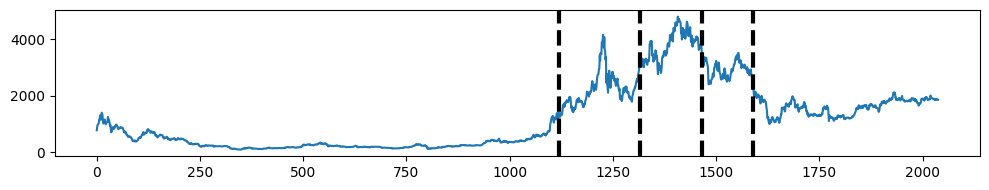

In [15]:
pen_values = np.linspace(1, 50000000, 50)

#BEST BIC dependiendo de la penalizacion xddd
best_pen = None
best_bic = np.inf

for pen in pen_values:
    bic = evaluate_penalty_bic(historico, pen)
    if bic < best_bic:
        best_bic = bic
        best_pen = pen

print(f"Mejor penalización: {best_pen}, Mejor BIC: {best_bic}")

algo = rpt.Pelt(model="l2", min_size=28)
algo.fit(historico)
result = algo.predict(pen=best_pen)

plt.figure(figsize=(20, 20))  
rpt.display(historico, [], result)
plt.show()

In [16]:
segments = []
start_idx = 0
for change_point in result:
    end_idx = change_point
    segment = historico[start_idx:end_idx]
    segments.append(segment)
    start_idx = end_idx

Segmento 1: Umbral = 230.39, Shape = -0.08, Loc = 0.18, Scale = 308.54


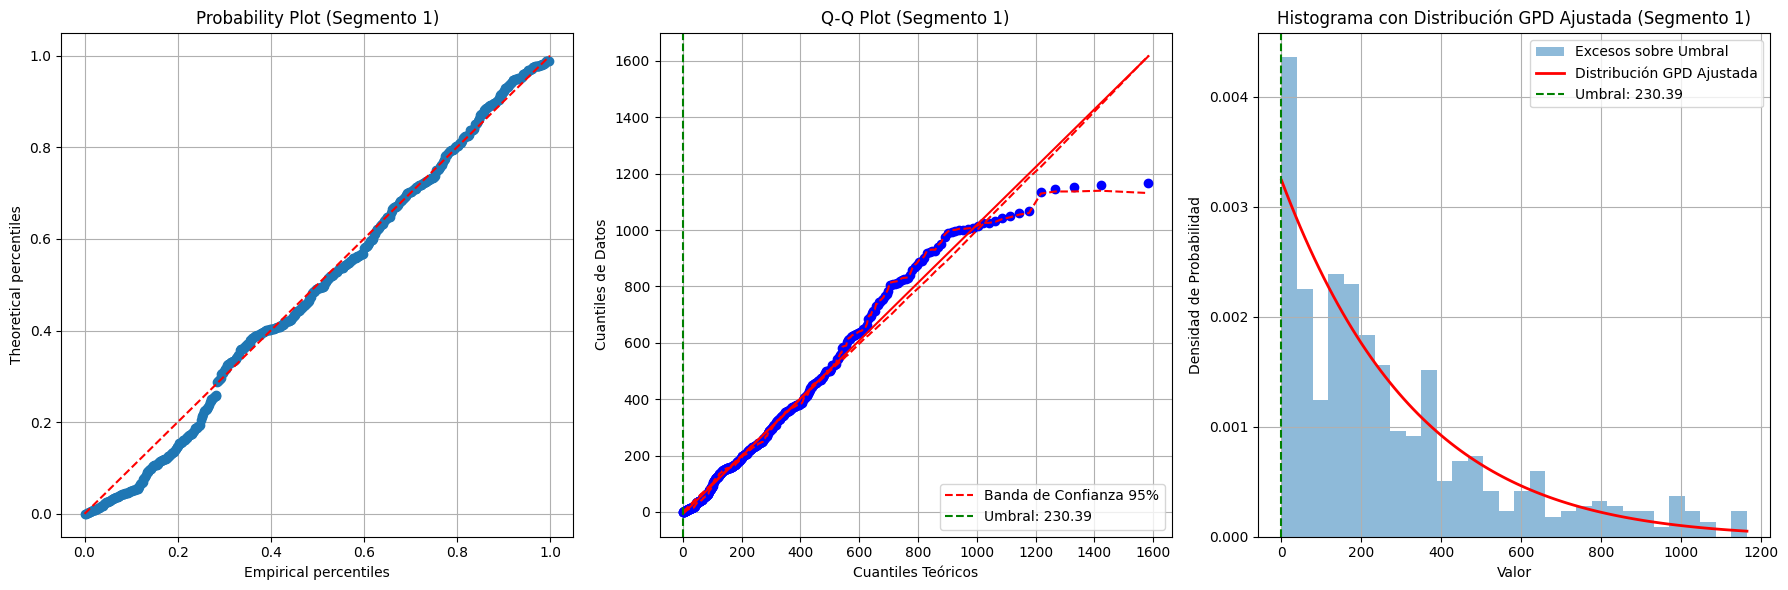

Segmento 2: Umbral = 2124.78, Shape = -0.05, Loc = 11.17, Scale = 553.07


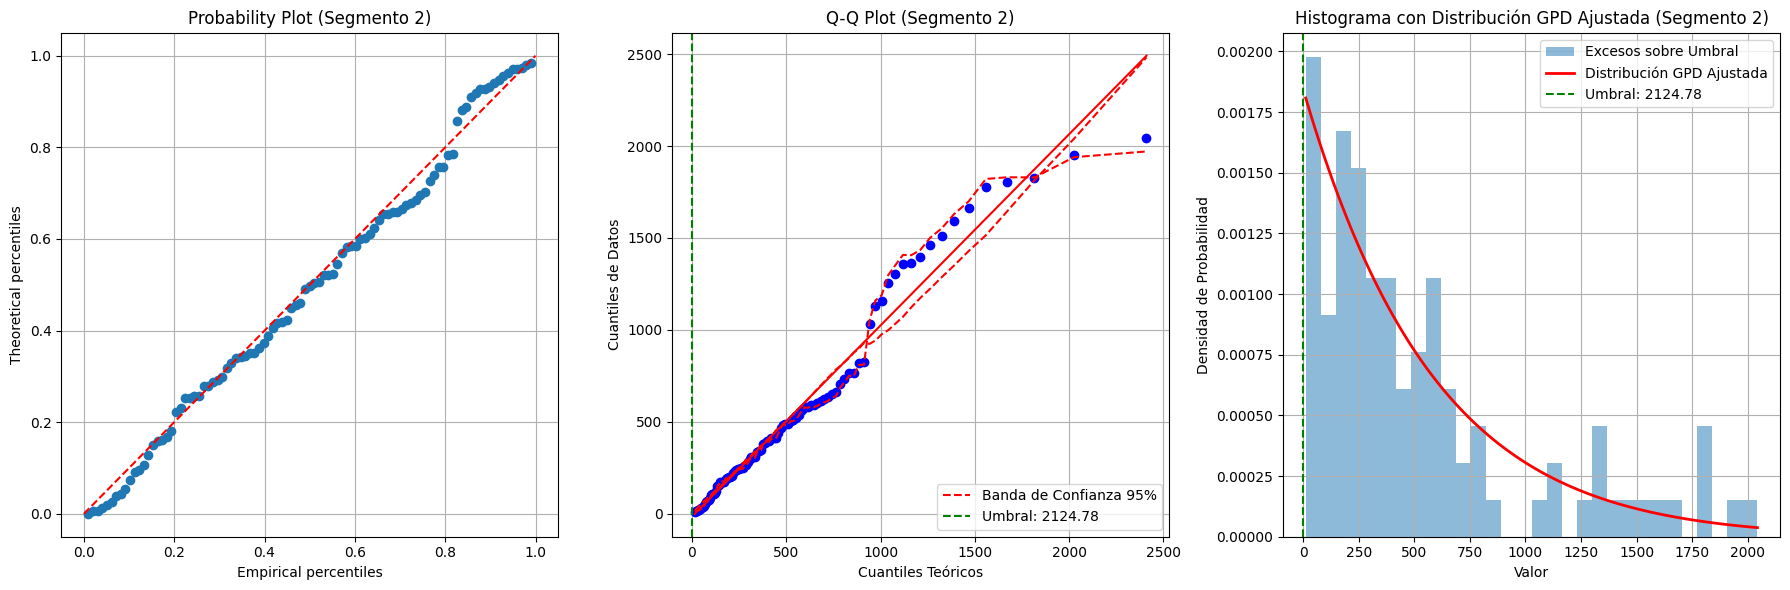

Segmento 3: Umbral = 3832.61, Shape = -0.67, Loc = 2.22, Scale = 662.16


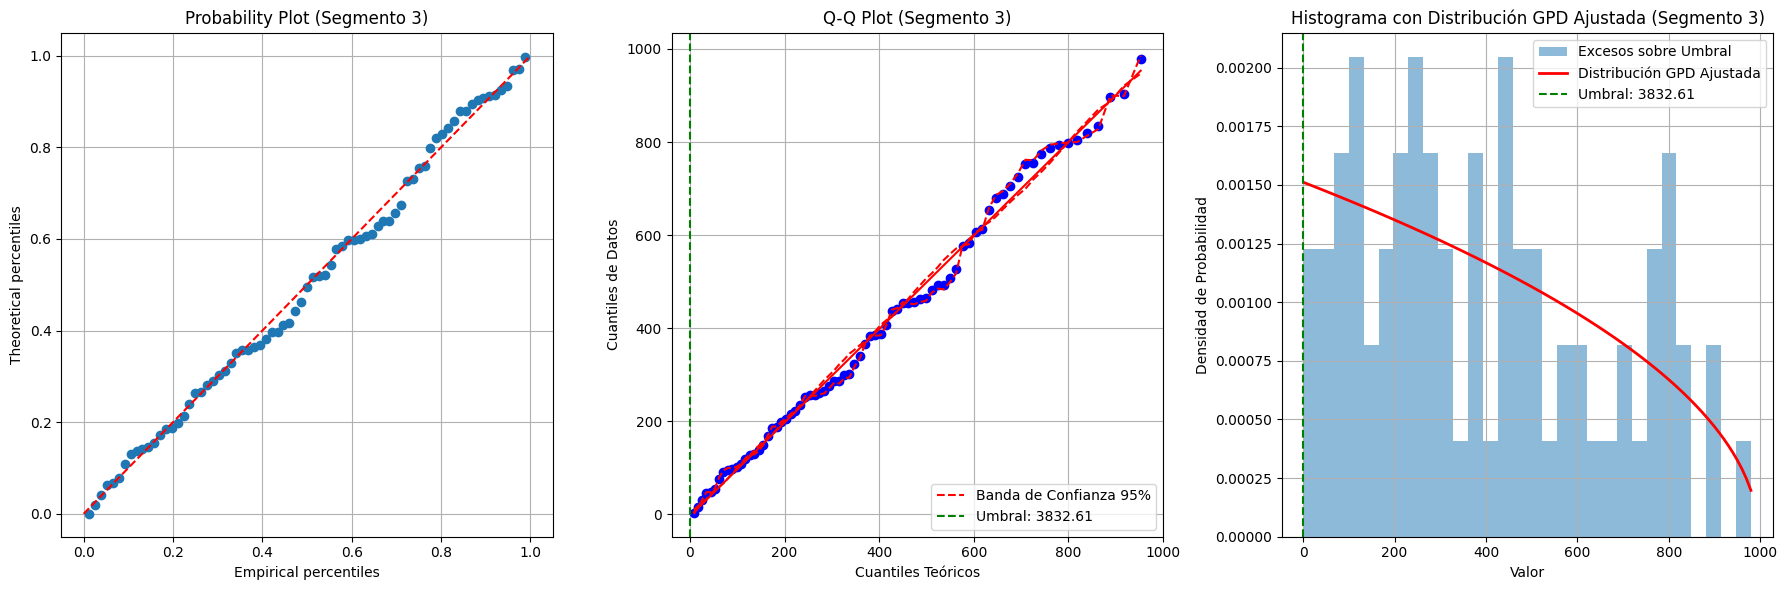

Segmento 4: Umbral = 2940.64, Shape = -0.55, Loc = 4.70, Scale = 355.32


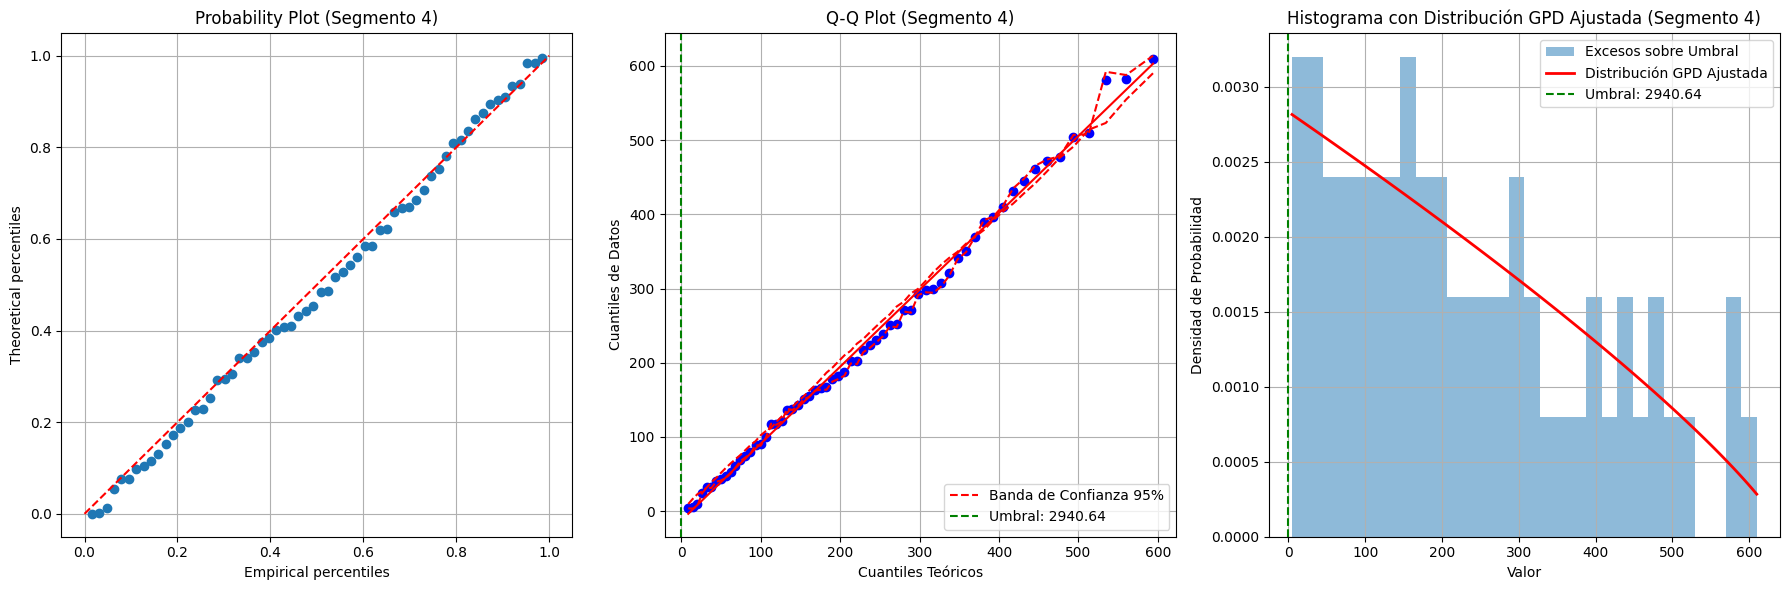

Segmento 5: Umbral = 1633.64, Shape = -0.34, Loc = 0.69, Scale = 252.79


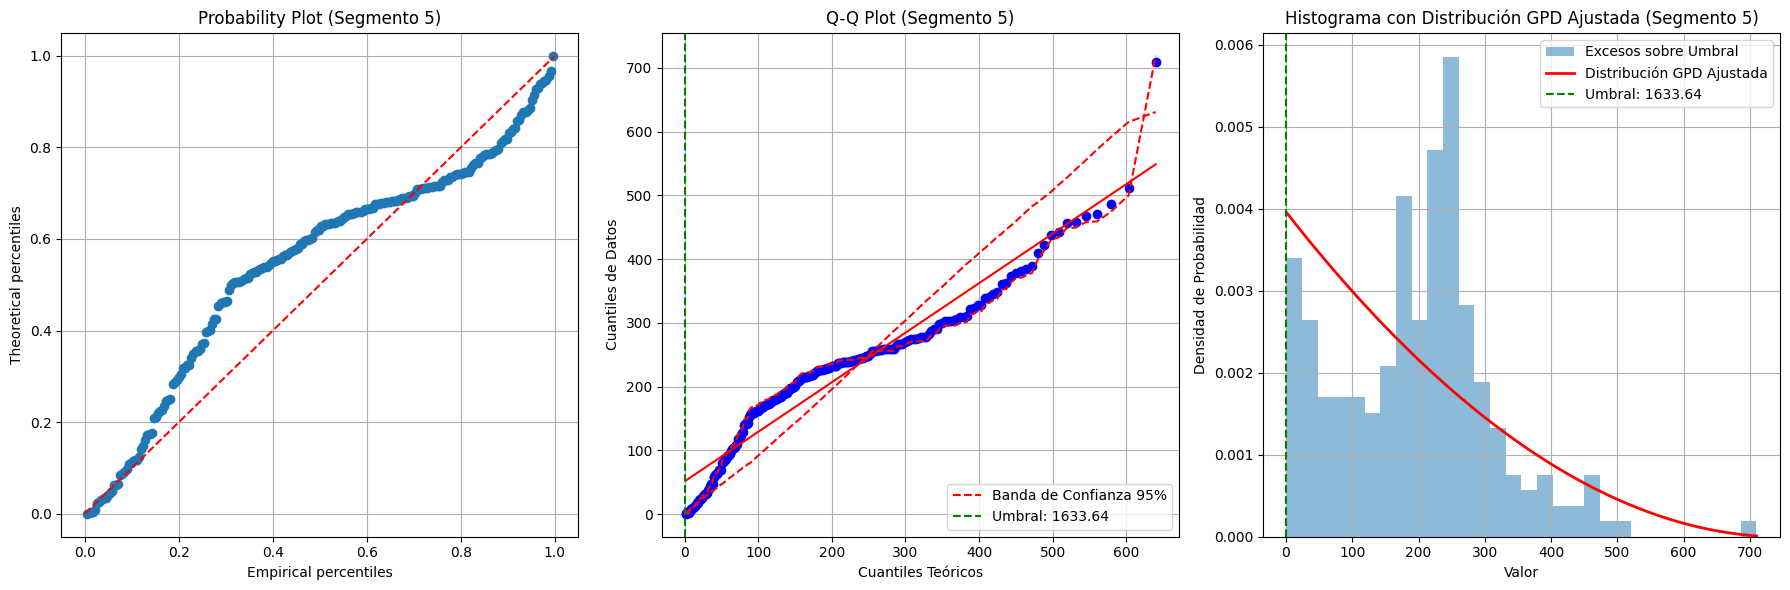

In [17]:
alpha = 0.05
for i, segment in enumerate(segments):
    segment_df = pd.DataFrame(segment, columns=['value'])
    data = segment_df['value']

    umbral_chido = find_threshold(data)
    umbral = umbral_chido
    excesos = data[data > umbral] - umbral

    if len(excesos) > 0:
        shape, loc, scale = genpareto.fit(excesos)
        print(f"Segmento {i+1}: Umbral = {umbral_chido:.2f}, Shape = {shape:.2f}, Loc = {loc:.2f}, Scale = {scale:.2f}")
        
        ####P-P plot
        plt.figure(figsize=(18, 6))
        
        excesos_sorted = np.sort(excesos)
        empirical_percentiles = np.arange(1, len(excesos_sorted) + 1) / (len(excesos_sorted) + 1)
        theoretical_percentiles = genpareto.cdf(excesos_sorted, c=shape, loc=loc, scale=scale)
        
        plt.subplot(1, 3, 1)
        plt.plot(empirical_percentiles, theoretical_percentiles, 'o')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Empirical percentiles')
        plt.ylabel('Theoretical percentiles')
        plt.title(f'Probability Plot (Segmento {i+1})')
        plt.grid(True)

        ####Q-Q plot
        plt.subplot(1, 3, 2)
        res = stats.probplot(excesos, dist="genpareto", sparams=(shape, loc, scale), plot=plt)
        plt.title(f'Q-Q Plot (Segmento {i+1})')
        
        percs = np.linspace(0, 100, len(excesos))
        ql = np.percentile(res[0][0], percs)
        qu = np.percentile(res[0][1], percs)
        z = stats.norm.ppf(1 - alpha/2)
        se = (qu - ql) / np.sqrt(len(excesos))
        ci_low = ql - z * se
        ci_high = qu + z * se
        
        plt.plot(ql, ci_low, linestyle='--', color='r', label='Banda de Confianza 95%')
        plt.plot(ql, ci_high, linestyle='--', color='r')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Cuantiles Teóricos')
        plt.ylabel('Cuantiles de Datos')
        plt.grid(True)
        plt.legend()
        
        #AAAAAAAAAAAAHHHHHHHHHHHHHH MORE HISTOGRAMAS AAAAAAAAAAHHHHH
        plt.subplot(1, 3, 3)
        plt.hist(excesos, bins=30, density=True, alpha=0.5, label='Excesos sobre Umbral')
        x = np.linspace(min(excesos), max(excesos), 100)
        y = stats.genpareto.pdf(x, shape, loc, scale)
        plt.plot(x, y, 'r-', lw=2, label='Distribución GPD Ajustada')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Valor')
        plt.ylabel('Densidad de Probabilidad')
        plt.title(f'Histograma con Distribución GPD Ajustada (Segmento {i+1})')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

### Ahora hacemos esto para las diferencias


In [18]:
diff_segments = [np.diff(segment, axis=0) for segment in segments]
segments = diff_segments

Segmento 1: Umbral = 0.13, Shape = 0.48, Loc = 0.02, Scale = 7.63


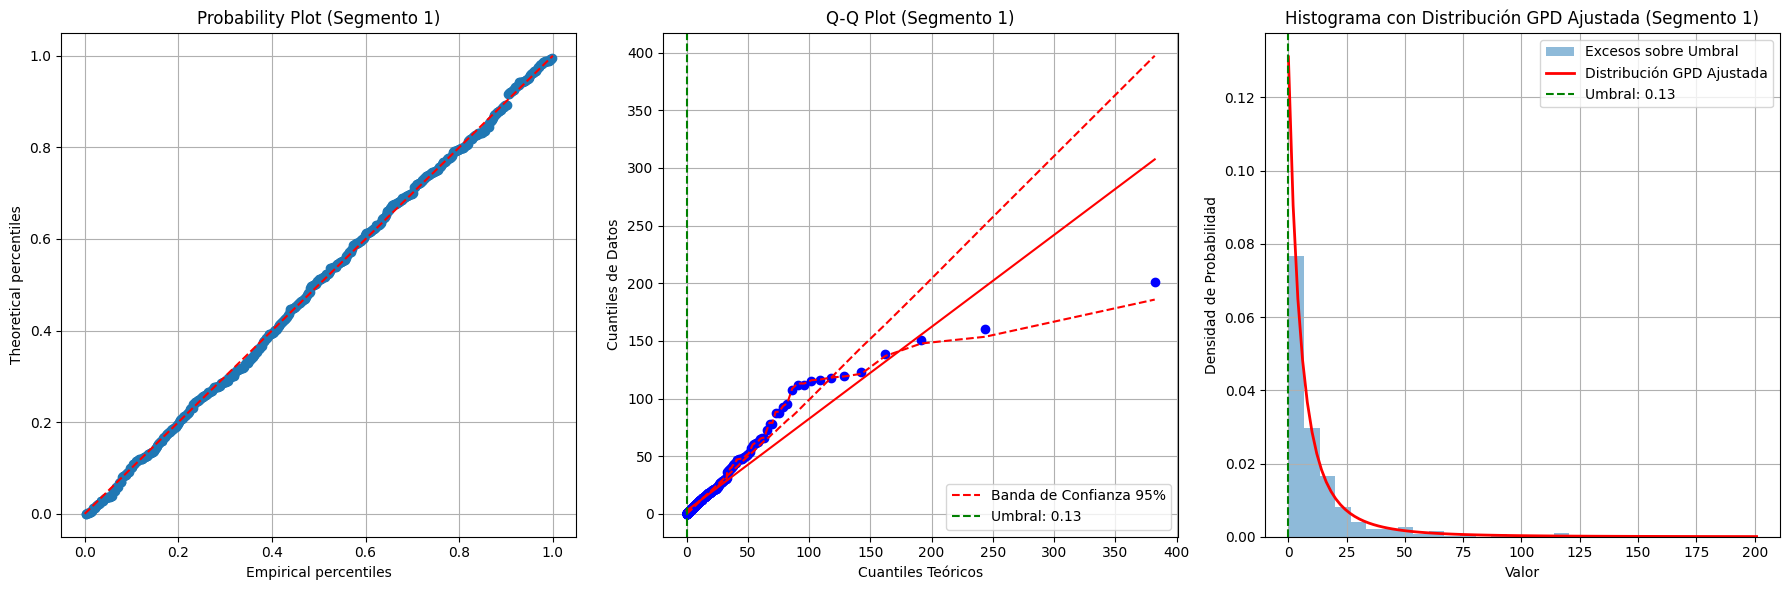

Segmento 2: Umbral = 16.40, Shape = 0.02, Loc = 0.07, Scale = 91.94


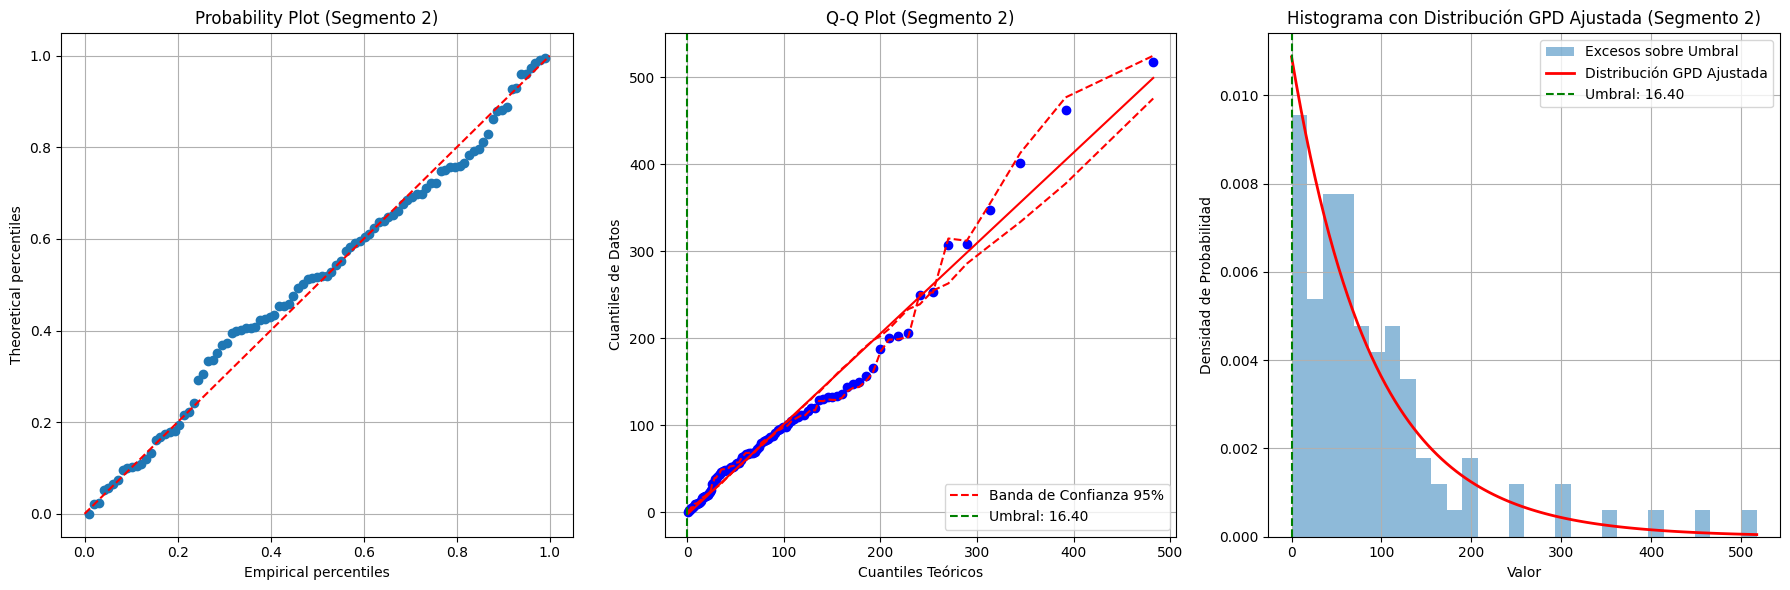

Segmento 3: Umbral = 5.24, Shape = -0.34, Loc = 2.17, Scale = 156.54


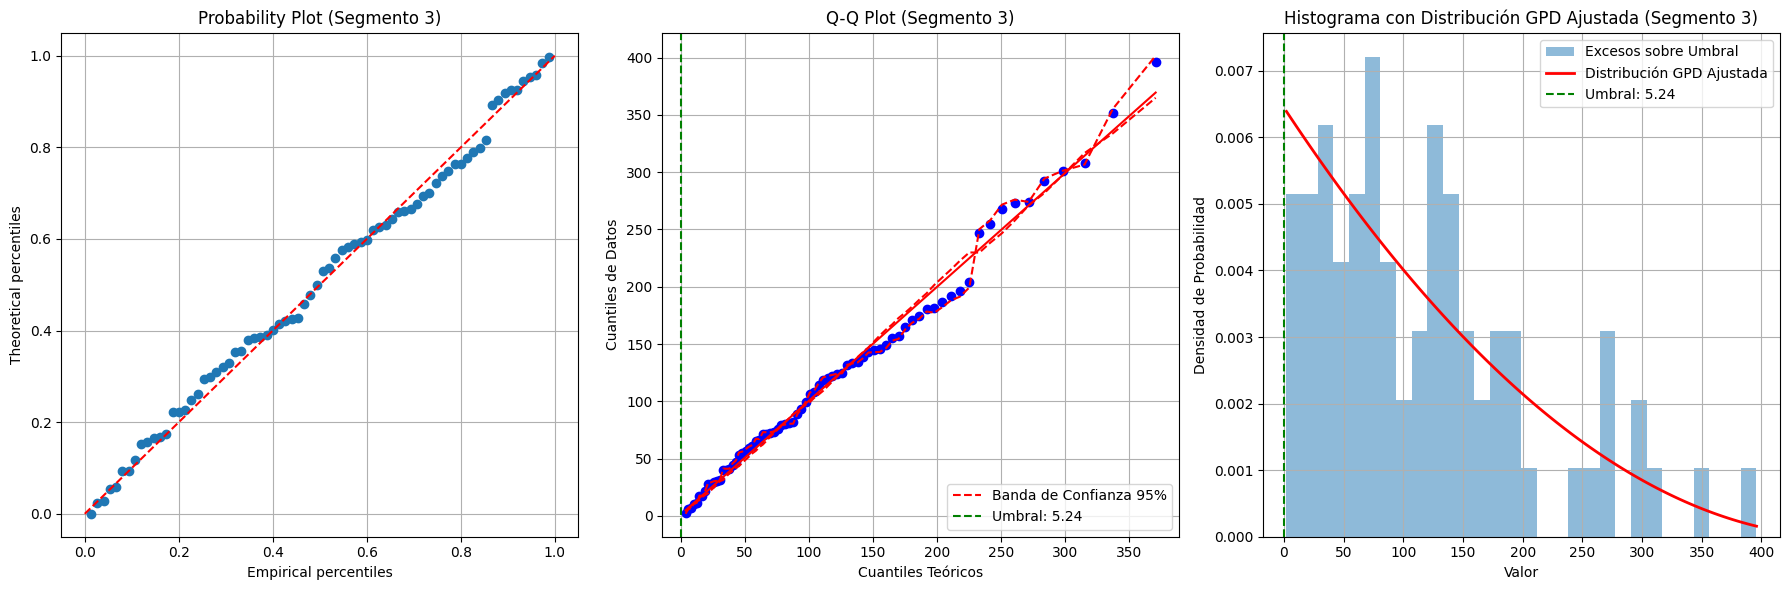

Segmento 4: Umbral = -1.49, Shape = -0.20, Loc = 0.10, Scale = 96.27


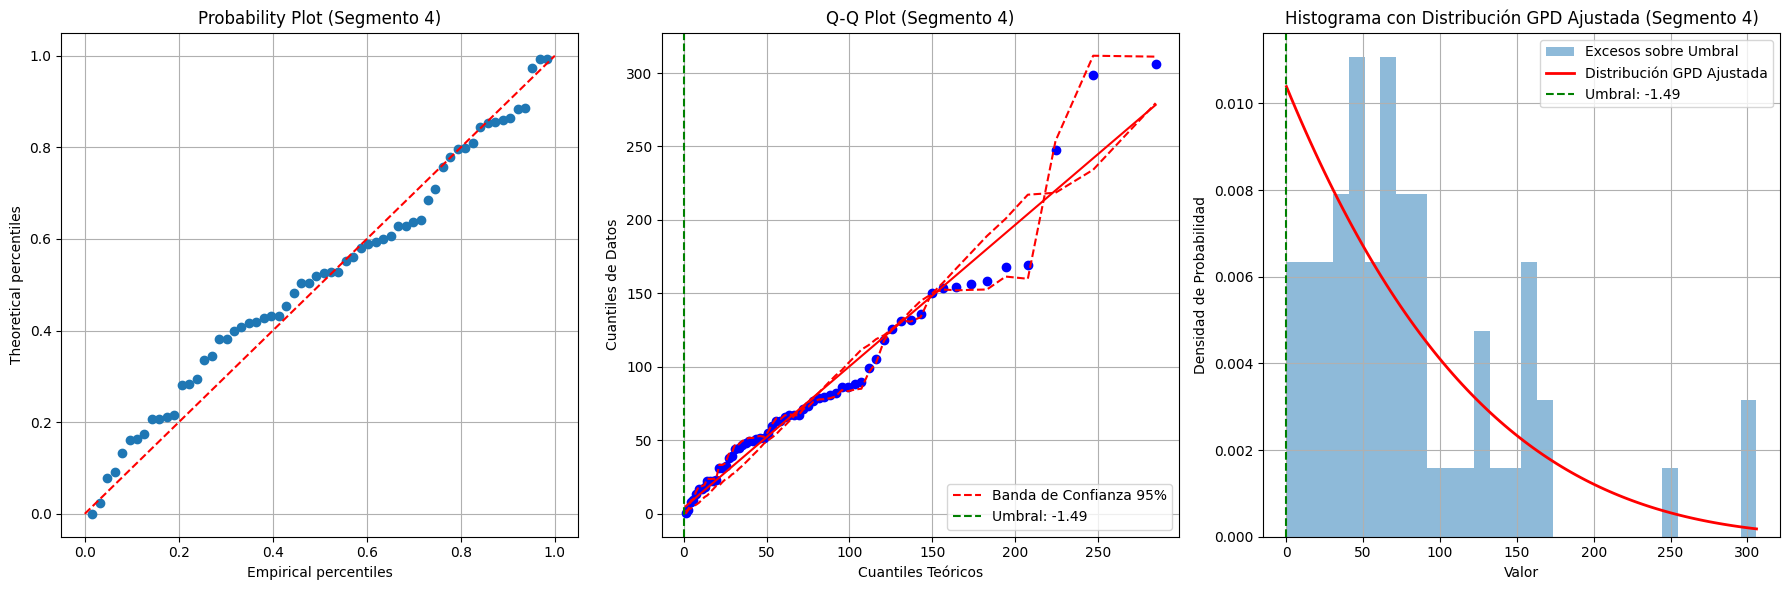

Segmento 5: Umbral = -2.24, Shape = -0.05, Loc = 0.02, Scale = 43.89


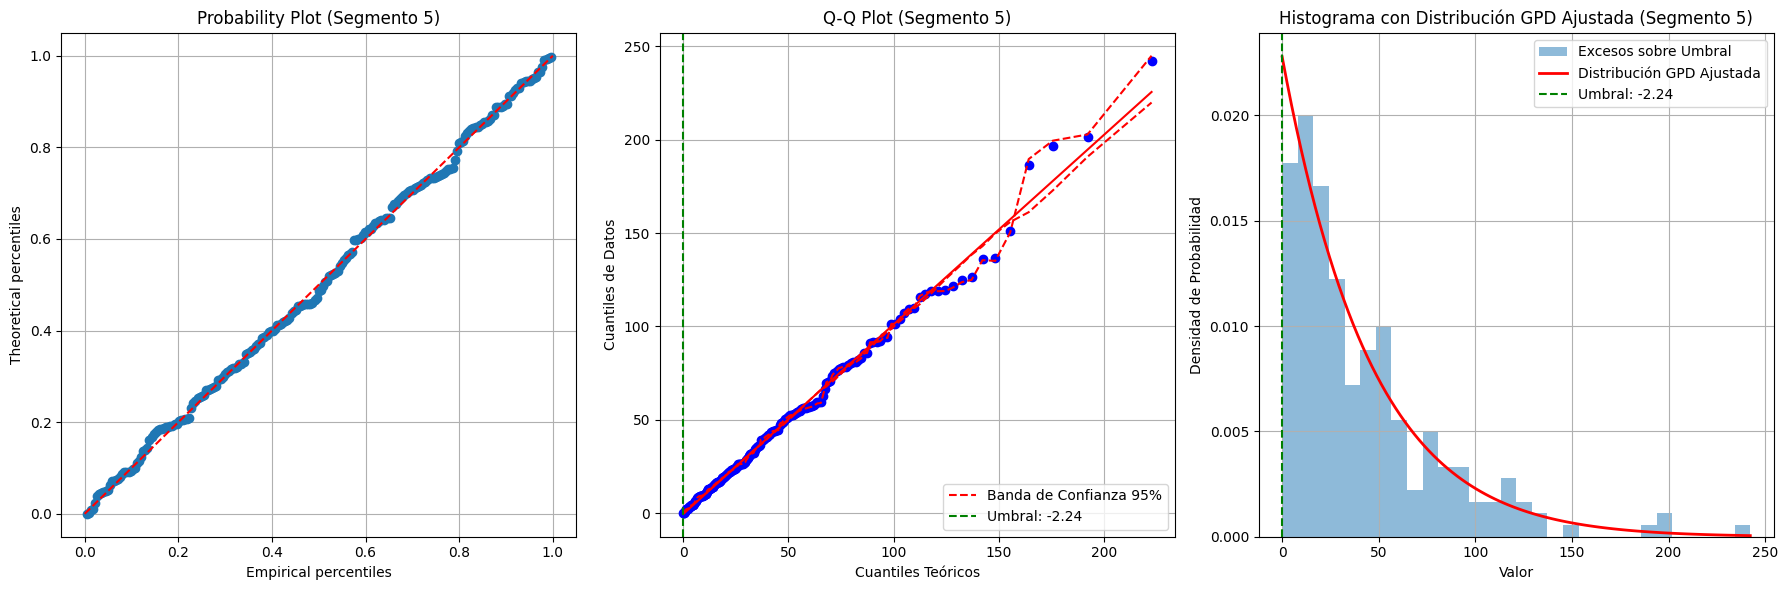

In [19]:
for i, segment in enumerate(segments):
    segment_df = pd.DataFrame(segment, columns=['value'])
    data = segment_df['value']

    umbral_chido = find_threshold(data)
    umbral = umbral_chido
    excesos = data[data > umbral] - umbral

    if len(excesos) > 0:
        shape, loc, scale = genpareto.fit(excesos)
        print(f"Segmento {i+1}: Umbral = {umbral_chido:.2f}, Shape = {shape:.2f}, Loc = {loc:.2f}, Scale = {scale:.2f}")
        
        # P-P plot
        plt.figure(figsize=(18, 6))
        
        excesos_sorted = np.sort(excesos)
        empirical_percentiles = np.arange(1, len(excesos_sorted) + 1) / (len(excesos_sorted) + 1)
        theoretical_percentiles = genpareto.cdf(excesos_sorted, c=shape, loc=loc, scale=scale)
        
        plt.subplot(1, 3, 1)
        plt.plot(empirical_percentiles, theoretical_percentiles, 'o')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Empirical percentiles')
        plt.ylabel('Theoretical percentiles')
        plt.title(f'Probability Plot (Segmento {i+1})')
        plt.grid(True)

        # Q-Q plot
        plt.subplot(1, 3, 2)
        res = stats.probplot(excesos, dist="genpareto", sparams=(shape, loc, scale), plot=plt)
        plt.title(f'Q-Q Plot (Segmento {i+1})')
        
        percs = np.linspace(0, 100, len(excesos))
        ql = np.percentile(res[0][0], percs)
        qu = np.percentile(res[0][1], percs)
        z = stats.norm.ppf(1 - alpha/2)
        se = (qu - ql) / np.sqrt(len(excesos))
        ci_low = ql - z * se
        ci_high = qu + z * se
        
        plt.plot(ql, ci_low, linestyle='--', color='r', label='Banda de Confianza 95%')
        plt.plot(ql, ci_high, linestyle='--', color='r')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Cuantiles Teóricos')
        plt.ylabel('Cuantiles de Datos')
        plt.grid(True)
        plt.legend()
        
        # Histograma con la distribución GPD ajustada
        plt.subplot(1, 3, 3)
        plt.hist(excesos, bins=30, density=True, alpha=0.5, label='Excesos sobre Umbral')
        x = np.linspace(min(excesos), max(excesos), 100)
        y = stats.genpareto.pdf(x, shape, loc, scale)
        plt.plot(x, y, 'r-', lw=2, label='Distribución GPD Ajustada')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Valor')
        plt.ylabel('Densidad de Probabilidad')
        plt.title(f'Histograma con Distribución GPD Ajustada (Segmento {i+1})')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [20]:
simulated_data = []
real_cdfs = []

for i, segment_diff in enumerate(diff_segments):
    if len(segment_diff) > 0:
        segment_diff_df = pd.DataFrame(segment_diff.reshape(-1, 1), columns=['value'])
        data = segment_diff_df['value']

        #####---------Encontrar el umbral óptimo---------- Segun el paper xddddd####
        umbral_chido = find_threshold(data)
        umbral = umbral_chido
        excesos = data[data > umbral] - umbral

        if len(excesos) > 0:
            #$$$$$$$$$$$$$$$$$$$$4 Aqui simplemente ajustamos la GPD a los excesos-------
            shape, loc, scale = genpareto.fit(excesos)
            
            #---Ajustamos una distribucion kernel a los datos menores o iguales al umbral-----
            kernel_data = data[data <= umbral]
            kde = gaussian_kde(kernel_data)

            #########Simular nuevos datos---------
            num_simulations = 1000
            simulated_segment = []

            for _ in range(num_simulations):
                if random.random() > 0.5:
                    simulated_value = kde.resample(1)[0][0]  #######Obtener el valor escalar de la muestra :DDDDDDDDDDDDDDDD
                else:
                    simulated_value = umbral + genpareto.rvs(c=shape, loc=loc, scale=scale)
                simulated_segment.append(simulated_value)  ########Agregar el valor escalar

            simulated_data.append(np.array(simulated_segment))
            
              # Calcular la CDF de los datos reales (ajustados)
            sorted_real_data = np.sort(data)
            cdf_real_data = np.arange(1, len(sorted_real_data) + 1) / len(sorted_real_data)
            real_cdfs.append((sorted_real_data, cdf_real_data))
            

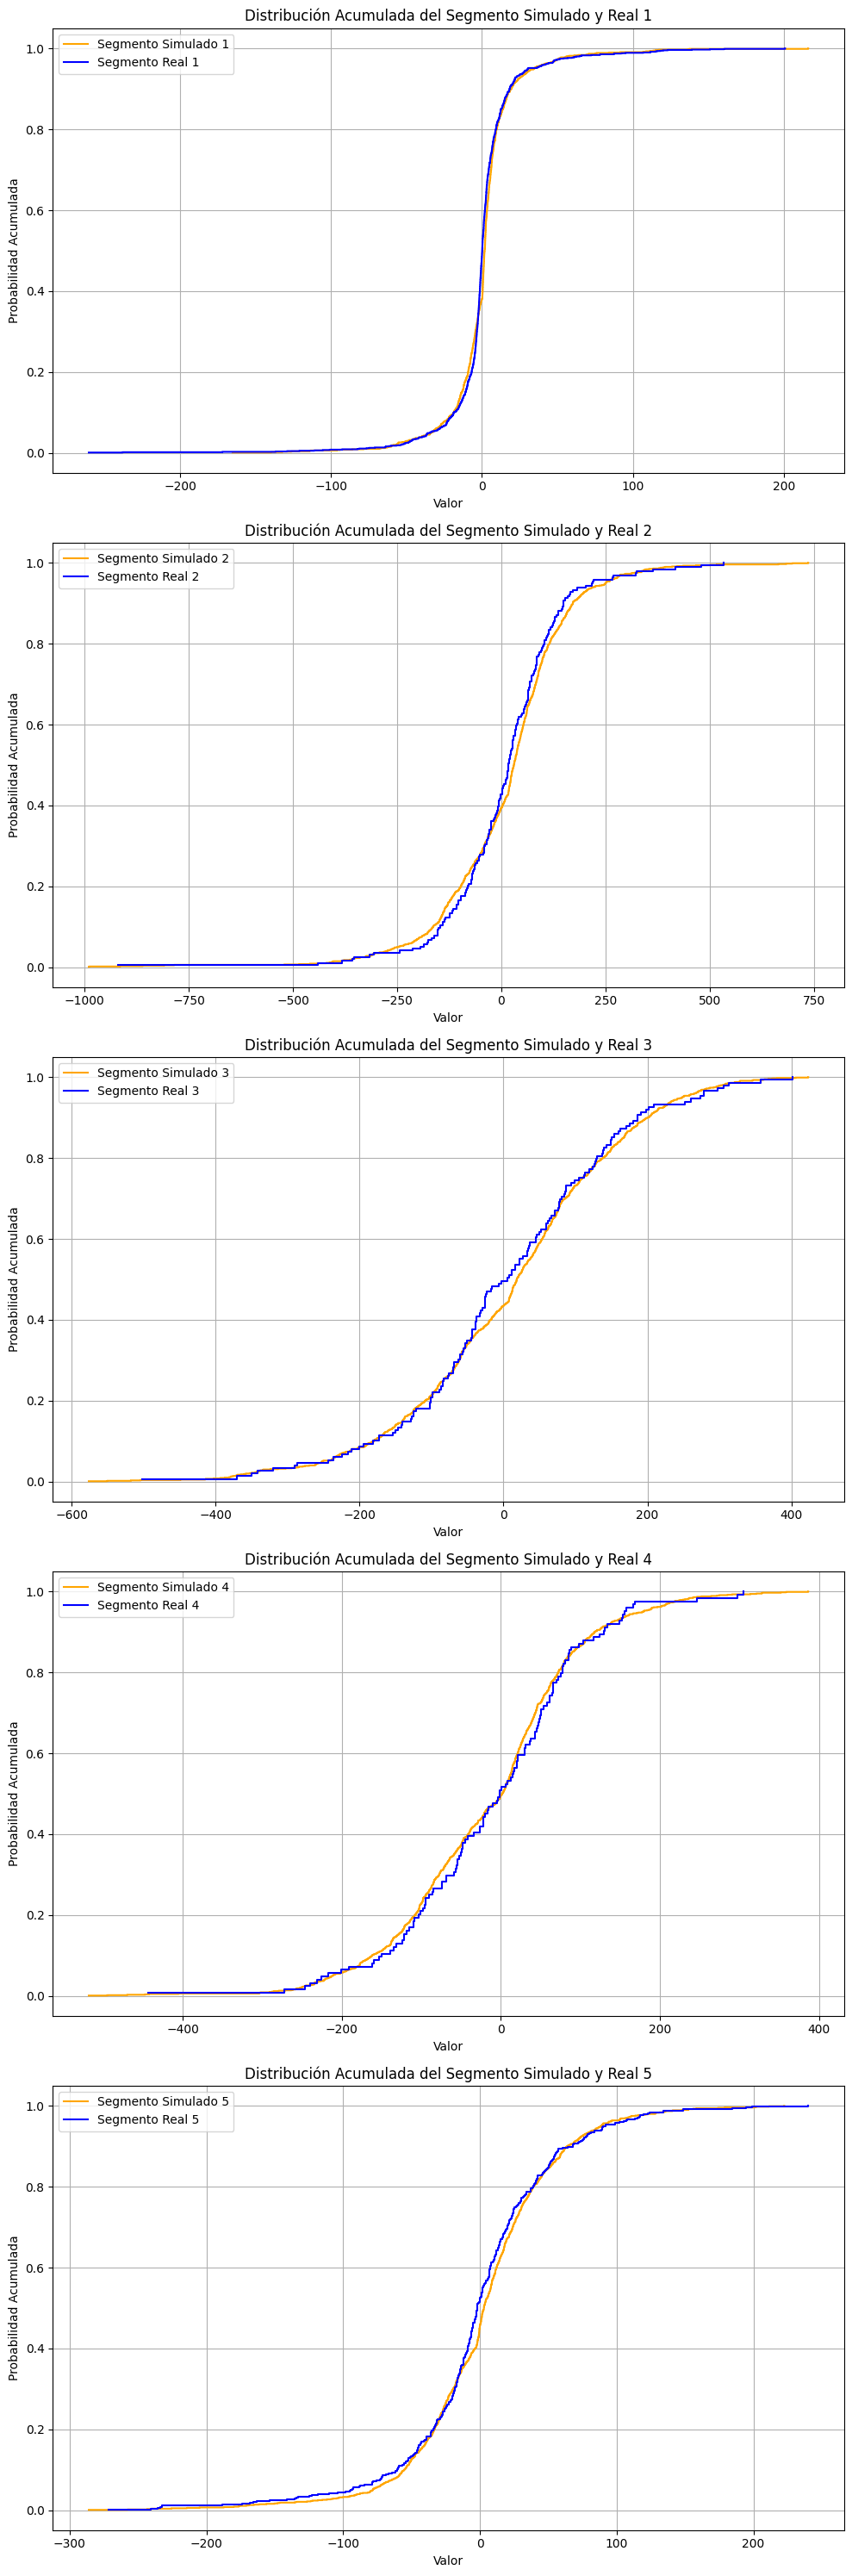

In [21]:
###Plot de las CDFs de cada segmento simulado y real (ajustado) en la misma gráfica
num_segments = len(simulated_data)
fig, axes = plt.subplots(num_segments, 1, figsize=(10, 6 * num_segments))
if num_segments == 1:
    axes = [axes]

for i, (sim_data, real_data, ax) in enumerate(zip(simulated_data, real_cdfs, axes), 1):
    # Datos simulados
    sorted_sim_data = np.sort(sim_data)
    cdf_sim_data = np.arange(1, len(sorted_sim_data) + 1) / len(sorted_sim_data)
    ax.step(sorted_sim_data, cdf_sim_data, where='post', color='orange', label=f'Segmento Simulado {i}')
    
    # Datos reales ajustados
    sorted_real_data, cdf_real_data = real_data
    ax.step(sorted_real_data, cdf_real_data, where='post', color='blue', label=f'Segmento Real {i}')
    
    ax.set_title(f'Distribución Acumulada del Segmento Simulado y Real {i}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Probabilidad Acumulada')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

/tmp/ipykernel_144777/624589975.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_data, shade=True, color='orange', label=f'Segmento Simulado {i}', ax=ax)
/tmp/ipykernel_144777/624589975.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(real_data, shade=True, color='blue', label=f'Segmento Real {i}', ax=ax)
/tmp/ipykernel_144777/624589975.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(sim_data, shade=True, color='orange', label=f'Segmento Simulado {i}', ax=ax)
/tmp/ipykernel_144777/624589975.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error 

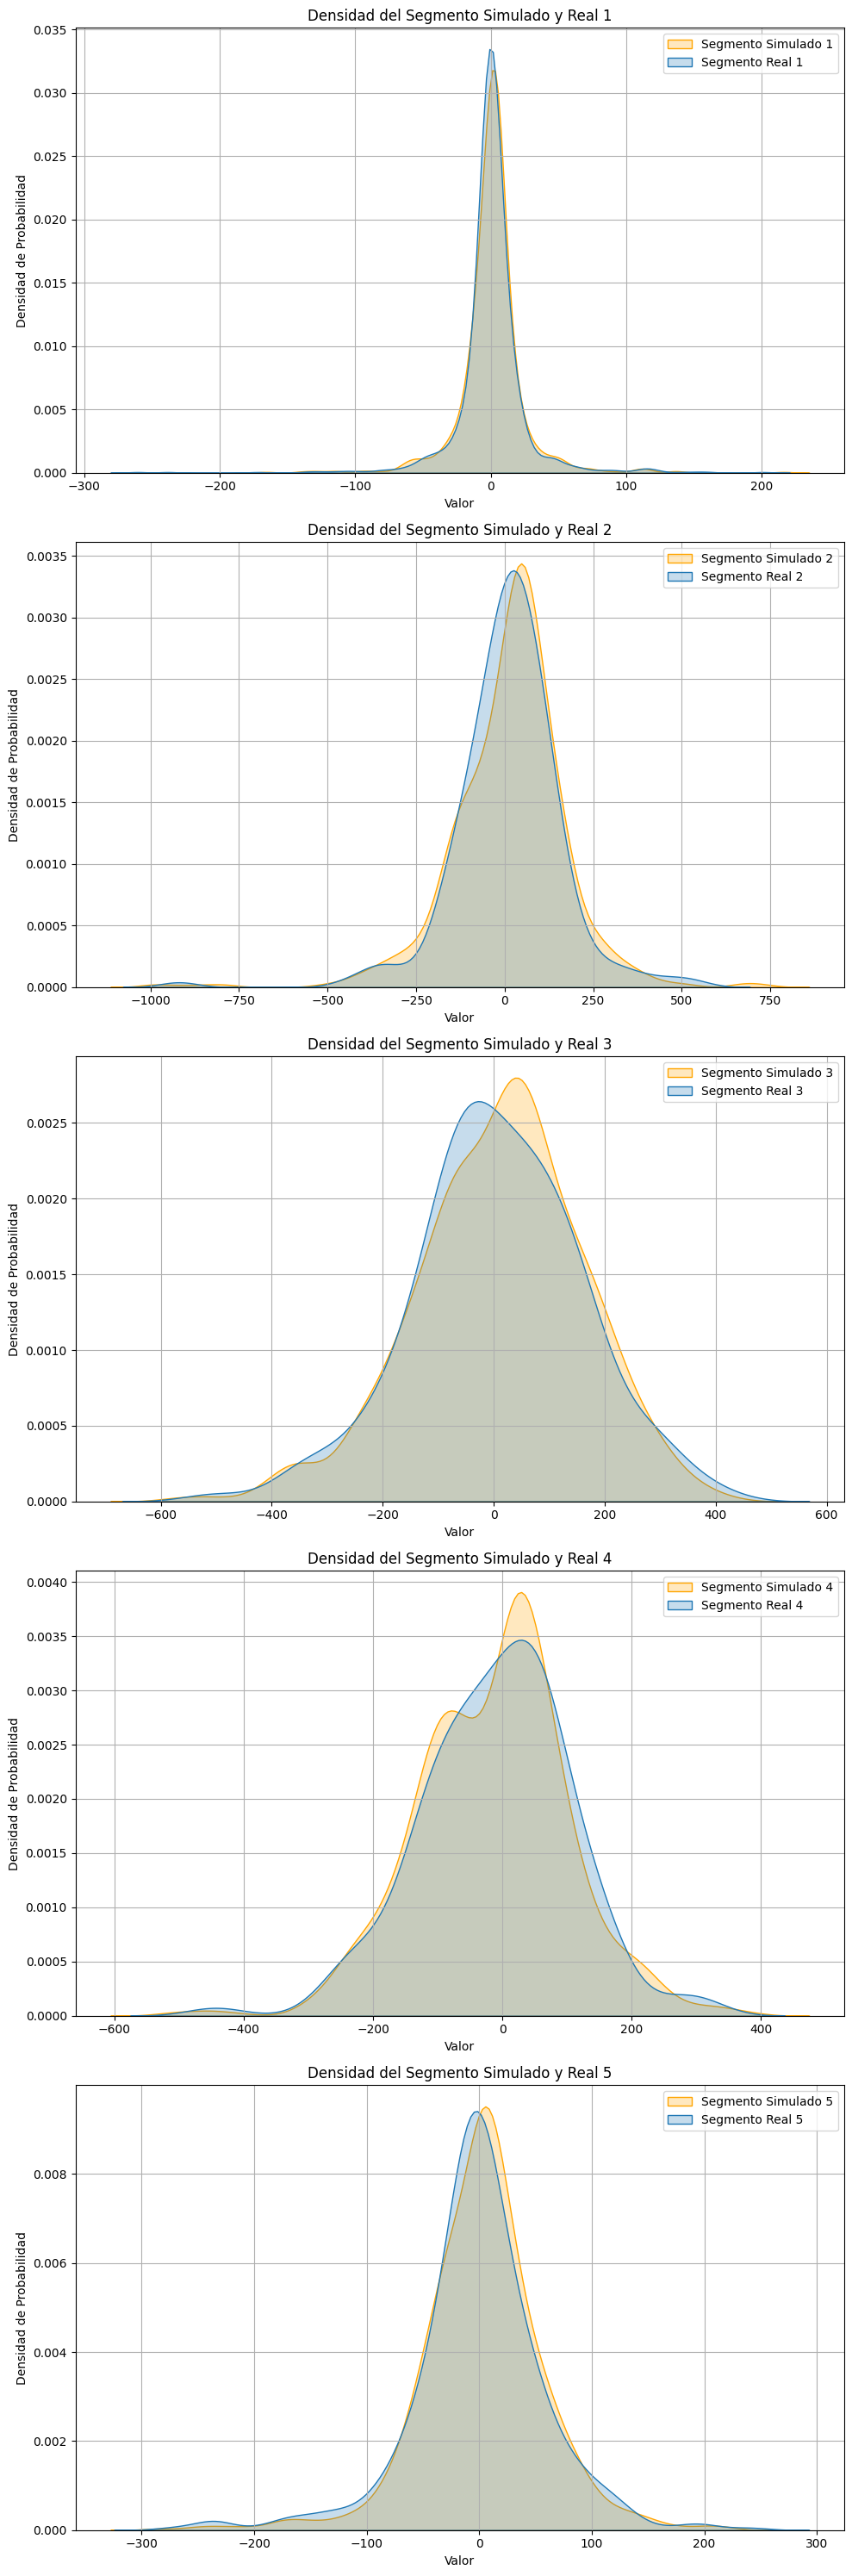

In [22]:
num_segments = len(simulated_data)
fig, axes = plt.subplots(num_segments, 1, figsize=(10, 6 * num_segments))
if num_segments == 1:
    axes = [axes]
for i, (sim_data, real_data, ax) in enumerate(zip(simulated_data, diff_segments, axes), 1):
    ###################Aqui le datos simulados
    sns.kdeplot(sim_data, shade=True, color='orange', label=f'Segmento Simulado {i}', ax=ax)
    
    #Aqui le datos reales
    sns.kdeplot(real_data, shade=True, color='blue', label=f'Segmento Real {i}', ax=ax)
    
    ax.set_title(f'Densidad del Segmento Simulado y Real {i}')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad de Probabilidad')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

In [23]:
historico

array([[ 772.640991],
       [ 884.44397 ],
       [ 962.719971],
       ...,
       [1881.068848],
       [1861.643799],
       [1856.162354]])

In [24]:
temp = historico.flatten()

Mejor penalización: 18367.979591836734, Mejor BIC: 4468.519628557711


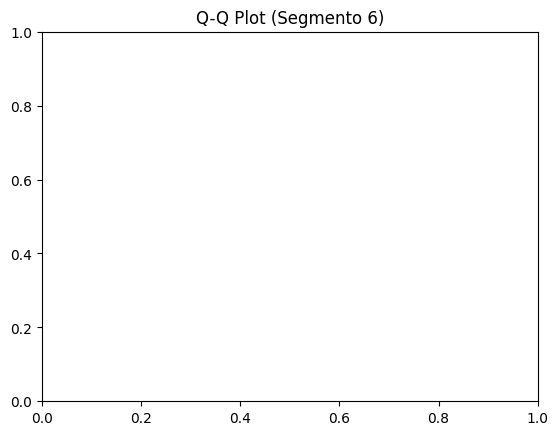

<Figure size 2000x2000 with 0 Axes>

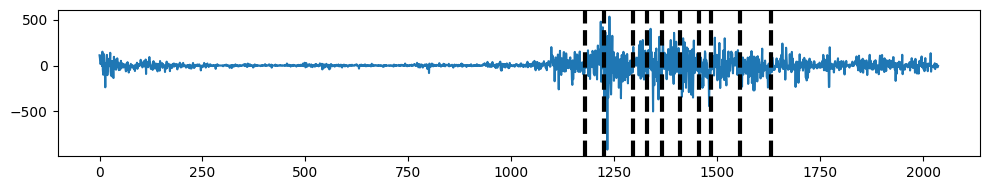

In [25]:
diff_historico = np.diff(temp)
pen_values = np.linspace(1, 50000, 50)
best_pen = None
best_bic = np.inf

for pen in pen_values:
    bic = evaluate_penalty_bic(diff_historico, pen)
    if bic < best_bic:
        best_bic = bic
        best_pen = pen

print(f"Mejor penalización: {best_pen}, Mejor BIC: {best_bic}")

algo = rpt.Pelt(model="l2", min_size=28)
algo.fit(diff_historico)
result = algo.predict(pen=best_pen)
#sparams=(shape, loc, scale), plot=plt
plt.title(f'Q-Q Plot (Segmento {i+1})')
plt.figure(figsize=(20,20))
rpt.display(diff_historico, [], result)
plt.show()

<Figure size 2000x2000 with 0 Axes>

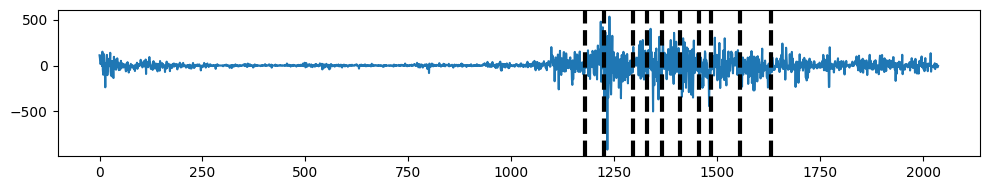

In [26]:
plt.figure(figsize=(20,20))
rpt.display(diff_historico, [], result)
plt.show()

### Una vez hecho esto vamos  a separar las diferencias en positivas y negativas para poder realizar los ajustes.

In [ ]:
segments = []
start_idx = 0
for change_point in result:
    end_idx = change_point
    segment = diff_historico[start_idx:end_idx]
    segments.append(segment)
    start_idx = end_idx

In [ ]:
# Análisis de cada segmento para tasas positivas y negativas por separado
for i, segment in enumerate(segments):
    segment_df = pd.DataFrame(segment, columns=['value'])
    data = segment_df['value']

    # Análisis de tasas positivas
    positive_data = data[data > 0]
    if len(positive_data) > 0:
        umbral_chido_pos = find_threshold(positive_data) 
        umbral_pos = umbral_chido_pos
        excesos_pos = positive_data[positive_data > umbral_pos] - umbral_pos

        if len(excesos_pos) > 0:
            shape_pos, loc_pos, scale_pos = genpareto.fit(excesos_pos)
            print(f"Segmento {i+1} (Positivo): Umbral = {umbral_chido_pos:.2f}, Shape = {shape_pos:.2f}, Loc = {loc_pos:.2f}, Scale = {scale_pos:.2f}")

            plt.figure(figsize=(18, 6))
            excesos_sorted = np.sort(excesos_pos)
            empirical_percentiles = np.arange(1, len(excesos_sorted) + 1) / (len(excesos_sorted) + 1)
            theoretical_percentiles = genpareto.cdf(excesos_sorted, c=shape_pos, loc=loc_pos, scale=scale_pos)

            plt.subplot(1, 3, 1)
            plt.plot(empirical_percentiles, theoretical_percentiles, 'o')
            plt.plot([0, 1], [0, 1], 'r--')
            plt.xlabel('Empirical percentiles')
            plt.ylabel('Theoretical percentiles')
            plt.title(f'Probability Plot (Segmento {i+1} - Positivo)')
            plt.grid(True)

            plt.subplot(1, 3, 2)
            res = probplot(excesos_pos, dist="genpareto", sparams=(shape_pos, loc_pos, scale_pos), plot=plt)
            plt.title(f'Q-Q Plot (Segmento {i+1} - Positivo)')

            percs = np.linspace(0, 100, len(excesos_pos))
            ql = np.percentile(res[0][0], percs)
            qu = np.percentile(res[0][1], percs)
            z = norm.ppf(1 - 0.05 / 2)
            se = (qu - ql) / np.sqrt(len(excesos_pos))
            ci_low = ql - z * se
            ci_high = qu + z * se

            plt.plot(ql, ci_low, linestyle='--', color='r', label='Banda de Confianza 95%')
            plt.plot(ql, ci_high, linestyle='--', color='r')
            plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido_pos:.2f}')
            plt.xlabel('Cuantiles Teóricos')
            plt.ylabel('Cuantiles de Datos')
            plt.grid(True)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.hist(excesos_pos, bins=30, density=True, alpha=0.5, label='Excesos sobre Umbral')
            x = np.linspace(min(excesos_pos), max(excesos_pos), 100)
            y = genpareto.pdf(x, shape_pos, loc=loc_pos, scale=scale_pos)
            plt.plot(x, y, 'r-', lw=2, label='Distribución GPD Ajustada')
            plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido_pos:.2f}')
            plt.xlabel('Valor')
            plt.ylabel('Densidad de Probabilidad')
            plt.title(f'Histograma con Distribución GPD Ajustada (Segmento {i+1} - Positivo)')
            plt.legend()
            plt.grid(True)

            plt.tight_layout()
            plt.show()

    # Análisis de tasas negativas
    negative_data = data[data < 0]
    abs_negative_data = np.abs(negative_data)
    if len(abs_negative_data) > 0:
        umbral_chido_neg = find_threshold(abs_negative_data) 
        umbral_neg = umbral_chido_neg
        excesos_neg = abs_negative_data[abs_negative_data > umbral_neg] - umbral_neg

        if len(excesos_neg) > 0:
            shape_neg, loc_neg, scale_neg = genpareto.fit(excesos_neg)
            print(f"Segmento {i+1} (Negativo): Umbral = {umbral_chido_neg:.2f}, Shape = {shape_neg:.2f}, Loc = {loc_neg:.2f}, Scale = {scale_neg:.2f}")

            plt.figure(figsize=(18, 6))
            excesos_sorted = np.sort(excesos_neg)
            empirical_percentiles = np.arange(1, len(excesos_sorted) + 1) / (len(excesos_sorted) + 1)
            theoretical_percentiles = genpareto.cdf(excesos_sorted, c=shape_neg, loc=loc_neg, scale=scale_neg)

            plt.subplot(1, 3, 1)
            plt.plot(empirical_percentiles, theoretical_percentiles, 'o')
            plt.plot([0, 1], [0, 1], 'r--')
            plt.xlabel('Empirical percentiles')
            plt.ylabel('Theoretical percentiles')
            plt.title(f'Probability Plot (Segmento {i+1} - Negativo)')
            plt.grid(True)

            plt.subplot(1, 3, 2)
            res = probplot(excesos_neg, dist="genpareto", sparams=(shape_neg, loc_neg, scale_neg), plot=plt)
            plt.title(f'Q-Q Plot (Segmento {i+1} - Negativo)')

            percs = np.linspace(0, 100, len(excesos_neg))
            ql = np.percentile(res[0][0], percs)
            qu = np.percentile(res[0][1], percs)
            z = norm.ppf(1 - 0.05 / 2)
            se = (qu - ql) / np.sqrt(len(excesos_neg))
            ci_low = ql - z * se
            ci_high = qu + z * se

            plt.plot(ql, ci_low, linestyle='--', color='r', label='Banda de Confianza 95%')
            plt.plot(ql, ci_high, linestyle='--', color='r')
            plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido_neg:.2f}')
            plt.xlabel('Cuantiles Teóricos')
            plt.ylabel('Cuantiles de Datos')
            plt.grid(True)
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.hist(excesos_neg, bins=30, density=True, alpha=0.5, label='Excesos sobre Umbral')
            x = np.linspace(min(excesos_neg), max(excesos_neg), 100)
            y = genpareto.pdf(x, shape_neg, loc=loc_neg, scale=scale_neg)
            plt.plot(x, y, 'r-', lw=2, label='Distribución GPD Ajustada')
            plt.axvline(x=0, color='g', linestyle='--', label=f')

In [ ]:
# Análisis de cada segmento para tasas positivas y negativas por separado
simulated_data = []
real_cdfs = []
simulated_cdfs = []

for i, segment in enumerate(segments):
    if len(segment) > 0:
        segment_df = pd.DataFrame(segment.reshape(-1, 1), columns=['value'])
        data = segment_df['value']

        # Análisis de tasas positivas
        positive_data = data[data > 0]
        umbral_chido_pos = find_threshold(positive_data) 
        umbral_pos = umbral_chido_pos
        excesos_pos = positive_data[positive_data > umbral_pos] - umbral_pos

        simulated_segment_pos = []
        if len(excesos_pos) > 0:
            shape_pos, loc_pos, scale_pos = genpareto.fit(excesos_pos)
            kernel_data_pos = positive_data[positive_data <= umbral_pos]
            kde_pos = gaussian_kde(kernel_data_pos)

            for _ in range(len(positive_data)):
                if random.random() > 0.5:
                    simulated_value = kde_pos.resample(1)[0][0]
                else:
                    simulated_value = umbral_pos + genpareto.rvs(c=shape_pos, loc=loc_pos, scale=scale_pos)
                simulated_segment_pos.append(simulated_value)

        # Análisis de tasas negativas
        negative_data = data[data < 0]
        abs_negative_data = np.abs(negative_data)
        umbral_chido_neg = find_threshold(abs_negative_data) 
        umbral_neg = umbral_chido_neg
        excesos_neg = abs_negative_data[abs_negative_data > umbral_neg] - umbral_neg

        simulated_segment_neg = []
        if len(excesos_neg) > 0:
            shape_neg, loc_neg, scale_neg = genpareto.fit(excesos_neg)
            kernel_data_neg = abs_negative_data[abs_negative_data <= umbral_neg]
            kde_neg = gaussian_kde(kernel_data_neg)

            for _ in range(len(negative_data)):
                if random.random() > 0.5:
                    simulated_value = -kde_neg.resample(1)[0][0]
                else:
                    simulated_value = -(umbral_neg + genpareto.rvs(c=shape_neg, loc=loc_neg, scale=scale_neg))
                simulated_segment_neg.append(simulated_value)

        # Combine positive and negative simulated segments
        simulated_segment = np.concatenate([simulated_segment_pos, simulated_segment_neg])
        simulated_data.append(np.array(simulated_segment))

        # Calcular la CDF de los datos reales
        sorted_real_data = np.sort(data)
        cdf_real_data = np.arange(1, len(sorted_real_data) + 1) / len(sorted_real_data)
        real_cdfs.append((sorted_real_data, cdf_real_data))

        # Calcular la CDF de los datos simulados
        sorted_simulated_data = np.sort(simulated_segment)
        cdf_simulated_data = np.arange(1, len(sorted_simulated_data) + 1) / len(sorted_simulated_data)
        simulated_cdfs.append((sorted_simulated_data, cdf_simulated_data))

# Graficar y comparar las CDFs de los datos reales y simulados en gráficos separados
num_segments = len(real_cdfs)
for i in range(num_segments):
    plt.figure(figsize=(12, 6))
    sorted_real_data, cdf_real_data = real_cdfs[i]
    sorted_simulated_data, cdf_simulated_data = simulated_cdfs[i]
    
    plt.step(sorted_real_data, cdf_real_data, where='post', label=f'Real CDF Segment {i+1}')
    plt.step(sorted_simulated_data, cdf_simulated_data, where='post', linestyle='-', label=f'Simulated CDF Segment {i+1}')
    
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.title(f'Comparison of Real and Simulated CDFs for Segment {i+1}')
    plt.legend()
    plt.show()

In [ ]:
segments = []
start_idx = 0
for change_point in result:
    end_idx = change_point
    segment = diff_historico[start_idx:end_idx]
    segments.append(segment)
    start_idx = end_idx

In [ ]:
for i, segment in enumerate(segments):
    segment_df = pd.DataFrame(segment, columns=['value'])
    data = segment_df['value']

    umbral_chido = find_threshold(data)
    umbral = umbral_chido
    excesos = data[data > umbral] - umbral

    if len(excesos) > 0:
        shape, loc, scale = genpareto.fit(excesos)
        print(f"Segmento {i+1}: Umbral = {umbral_chido:.2f}, Shape = {shape:.2f}, Loc = {loc:.2f}, Scale = {scale:.2f}")
        
        # P-P plot
        plt.figure(figsize=(18, 6))
        
        excesos_sorted = np.sort(excesos)
        empirical_percentiles = np.arange(1, len(excesos_sorted) + 1) / (len(excesos_sorted) + 1)
        theoretical_percentiles = genpareto.cdf(excesos_sorted, c=shape, loc=loc, scale=scale)
        
        plt.subplot(1, 3, 1)
        plt.plot(empirical_percentiles, theoretical_percentiles, 'o')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('Empirical percentiles')
        plt.ylabel('Theoretical percentiles')
        plt.title(f'Probability Plot (Segmento {i+1})')
        plt.grid(True)

        # Q-Q plot
        plt.subplot(1, 3, 2)
        res = stats.probplot(excesos, dist="genpareto", sparams=(shape, loc, scale), plot=plt)
        plt.title(f'Q-Q Plot (Segmento {i+1})')
        
        percs = np.linspace(0, 100, len(excesos))
        ql = np.percentile(res[0][0], percs)
        qu = np.percentile(res[0][1], percs)
        z = stats.norm.ppf(1 - alpha/2)
        se = (qu - ql) / np.sqrt(len(excesos))
        ci_low = ql - z * se
        ci_high = qu + z * se
        
        plt.plot(ql, ci_low, linestyle='--', color='r', label='Banda de Confianza 95%')
        plt.plot(ql, ci_high, linestyle='--', color='r')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Cuantiles Teóricos')
        plt.ylabel('Cuantiles de Datos')
        plt.grid(True)
        plt.legend()
        
        # Histograma con la distribución GPD ajustada
        plt.subplot(1, 3, 3)
        plt.hist(excesos, bins=30, density=True, alpha=0.5, label='Excesos sobre Umbral')
        x = np.linspace(min(excesos), max(excesos), 100)
        y = stats.genpareto.pdf(x, shape, loc, scale)
        plt.plot(x, y, 'r-', lw=2, label='Distribución GPD Ajustada')
        plt.axvline(x=0, color='g', linestyle='--', label=f'Umbral: {umbral_chido:.2f}')
        plt.xlabel('Valor')
        plt.ylabel('Densidad de Probabilidad')
        plt.title(f'Histograma con Distribución GPD Ajustada (Segmento {i+1})')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [ ]:
from scipy.stats import gaussian_kde

In [ ]:
diff_segments = segments

In [ ]:
simulated_data = []
real_cdfs = []
simulated_cdfs = []

for i, segment_diff in enumerate(diff_segments):
    if len(segment_diff) > 0:
        segment_diff_df = pd.DataFrame(segment_diff.reshape(-1, 1), columns=['value'])
        data = segment_diff_df['value']

        umbral_chido = find_threshold(data) 
        umbral = umbral_chido
        excesos = data[data > umbral] - umbral

        if len(excesos) > 0:
            #### se summmoneeaaa a los excesos
            shape, loc, scale = genpareto.fit(excesos)
            
            #---------se hace la KDE a los menores o igualesssss
            kernel_data = data[data <= umbral]
            kde = gaussian_kde(kernel_data)

            # Simu 
            num_simulations = len(data)  #........Asegurarse de que el número de simulaciones sea igual al tamaño del segmento
            simulated_segment = []

            for _ in range(num_simulations):
                if random.random() > 0.5:
                    simulated_value = kde.resample(1)[0][0]
                else:
                    simulated_value = umbral + genpareto.rvs(c=shape, loc=loc, scale=scale)
                simulated_segment.append(simulated_value)

            simulated_data.append(np.array(simulated_segment))
            
            # Calcular la CDF de los datos reales
            sorted_real_data = np.sort(data)
            cdf_real_data = np.arange(1, len(sorted_real_data) + 1) / len(sorted_real_data)
            real_cdfs.append((sorted_real_data, cdf_real_data))
            
            # Calcular la CDF de los datos simulados
            sorted_simulated_data = np.sort(simulated_segment)
            cdf_simulated_data = np.arange(1, len(sorted_simulated_data) + 1) / len(sorted_simulated_data)
            simulated_cdfs.append((sorted_simulated_data, cdf_simulated_data))

# Graficar y comparar las CDFs de los datos reales y simulados en gráficos separados
num_segments = len(real_cdfs)
for i in range(num_segments):
    plt.figure(figsize=(12, 6))
    sorted_real_data, cdf_real_data = real_cdfs[i]
    sorted_simulated_data, cdf_simulated_data = simulated_cdfs[i]
    
    plt.step(sorted_real_data, cdf_real_data, where='post', label=f'Real CDF Segment {i+1}')
    plt.step(sorted_simulated_data, cdf_simulated_data, where='post', linestyle='-', label=f'Simulated CDF Segment {i+1}')
    
    plt.xlabel('Value')
    plt.ylabel('CDF')
    plt.title(f'Comparison of Real and Simulated CDFs for Segment {i+1}')
    plt.legend()
    plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

for i, (sorted_real_data, cdf_real_data) in enumerate(real_cdfs):
    plt.step(sorted_real_data, cdf_real_data, where='post', label=f'Real CDF Segment {i+1}')

for i, (sorted_simulated_data, cdf_simulated_data) in enumerate(simulated_cdfs):
    plt.step(sorted_simulated_data, cdf_simulated_data, where='post', linestyle='--', label=f'Simulated CDF Segment {i+1}')

plt.xlabel('Value')
plt.ylabel('CDF')
plt.title('Comparison of Real and Simulated CDFs')
plt.legend()
plt.show()

In [ ]:
for i, (real_segment, simulated_segment) in enumerate(zip(diff_segments, simulated_data)):
    plt.figure(figsize=(12, 6))
     
    plt.scatter(range(len(real_segment)), real_segment, alpha=0.5, label=f'Segmento Real {i+1}', color='blue')
    plt.scatter(range(len(simulated_segment)), simulated_segment, alpha=0.5, label=f'Segmento Simulado {i+1}', color='orange')
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparacion de datos Reales & Simulados del segmento: {i+1}')
    plt.legend()
    plt.show()

In [ ]:
for i, (real_segment, simulated_segment) in enumerate(zip(diff_segments, simulated_data)):
    plt.figure(figsize=(12, 6))
    
    plt.plot(range(len(real_segment)), real_segment, label=f'Segmento Real {i+1}', color='blue', linestyle='-')
    plt.plot(range(len(simulated_segment)), simulated_segment, label=f'Segmento Simulado {i+1}', color='orange', linestyle='--')
    
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Comparison of Real and Simulated Time Series for Segment {i+1}')
    plt.legend()
    plt.show()

In [ ]:
original_segments = [np.cumsum(segment) for segment in diff_segments]
simulated_original_data = [np.cumsum(segment) for segment in simulated_data]

In [ ]:
original_segments = [np.insert(np.cumsum(segment), 0, historico[i][0]) for i, segment in enumerate(diff_segments)]
simulated_original_data = [np.insert(np.cumsum(segment), 0, historico[i][0]) for i, segment in enumerate(simulated_data)]

In [ ]:
num_segments = len(original_segments)

fig, axes = plt.subplots(num_segments, 1, figsize=(12, 6 * num_segments))

if num_segments == 1:
    axes = [axes]

for i, (real_segment, simulated_segment) in enumerate(zip(original_segments, simulated_original_data)):
    axes[i].plot(range(len(real_segment)), real_segment, label=f'Segmento Real {i+1}', color='blue', linestyle='-')
    axes[i].plot(range(len(simulated_segment)), simulated_segment, label=f'Segmento Simulado {i+1}', color='orange', linestyle='--')
    
    axes[i].set_xlabel('Index')
    axes[i].set_ylabel('Value')
    axes[i].set_title(f'Comparaciones reales vs simulados por segmento {i+1}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [ ]:
historico

In [ ]:
simulated_data

In [ ]:
diff_segments = np.diff(historico, axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense